<a href="https://www.kaggle.com/rsizem2/tps-11-21-handling-noisy-labels-w-cleanlab?scriptVersionId=85039699" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Learning with Mislabeled Data

In this notebook, we will explore the [cleanlab](https://github.com/cleanlab/cleanlab) library which provides functions for "finding, quantifying, and learning with label errors in datasets." In particular, we will do the following:

1. Use `get_noise_indices` to detect mislabeled training labels
2. Use the `LearningWithNoisyLabels` wrapper with various scikit-learn compatible models to make predictions despite the mislabeled data.

**Note:** We use the leaked training labels to test some of our cleanlab functions, however we won't use it to train any models.

## -- Credits --

This notebook was inspired by the following discussions/notebooks:

* [This discussion](https://www.kaggle.com/c/tabular-playground-series-nov-2021/discussion/285503) about the mislabeled training data and the [accompanying notebook](https://www.kaggle.com/motloch/nov21-mislabeled-25).
* [This notebook](https://www.kaggle.com/criskiev/game-over-or-eda-of-the-leaked-train-csv) where the [original training labels](https://www.kaggle.com/criskiev/november21) were posted. 
* [This notebook](https://www.kaggle.com/kalaikumarr/comparing-22-different-classification-models) which gets baselines for various models.
* [This notebook](https://www.kaggle.com/kaaveland/tps-nov-2021-some-models-that-work-ok) which tests various sklearn classifiers. I used this notebook to pick models (and sometimes parameters) to test with the `LearningWithNoisyLabels` wrapper.
* [This notebook](https://www.kaggle.com/sugamkhetrapal/tps-nov-2021-1-14-xgboost-linear) which uses XGBoost with linear models (rather than trees as usual).

Please check these out (and upvote them!).

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 8

# Install cleanlab
!pip install -q cleanlab

In [2]:
# Generic imports
import numpy as np
import pandas as pd
import time
import gc

# Hide warnings
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# cleanlab
import cleanlab
from cleanlab.pruning import get_noise_indices
from cleanlab.classification import LearningWithNoisyLabels

# Preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Models & Evaluation
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# Models
from sklearn.base import clone
from sklearn.utils.extmath import softmax
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


In [3]:
# Load data
original_train = pd.read_csv('../input/november21/train.csv')
train = pd.read_csv('../input/tabular-playground-series-nov-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-nov-2021/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-nov-2021/sample_submission.csv')

# Feature columns
features = [col for col in train.columns if col not in ['id', 'target']]

# Check that the two train.csv are the same (except for the target)
print(train[features].equals(original_train[features]))

# Save space
y_actual = original_train['target'].copy()
del original_train
gc.collect()

True


0

# 1. Find Label Errors

In this section we use cleanlab functions to detect which labels are mislabeled. In particular, we do the following:

1. Use logistic regression to estimate train label probabilities (from `predict_proba`)
2.  `get_noisy_indices` to get the mislabled examples
3. Compare with the actual mislabeled examples from the leaked training data.

In [4]:
# fix labels, assumes input is pandas dataframe/series
def fix_labels(X_train, y_train, y_actual):
    
    y_train = y_train.reset_index(drop = True)
    y_actual = y_actual.reset_index(drop = True)
    
    # Logistic regression
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            solver = 'saga', 
            random_state = RANDOM_SEED
        ),
    )

    # Label probabilities
    label_prob = cross_val_predict(
        estimator = pipeline,
        X = X_train,
        y = y_train,
        cv = StratifiedKFold(
            n_splits = NUM_FOLDS, 
            shuffle = True, 
            random_state = RANDOM_SEED
        ),
        n_jobs = -1,
        method = "predict_proba",
    )

    # Estimate label errors
    pred_errors = get_noise_indices(
        s = y_train,
        psx = label_prob,
        sorted_index_method='normalized_margin',
     )

    # Actual label errors
    actual_errors = y_actual.index[y_train != y_actual].to_numpy()
    
    # Indicator vectors for label errors
    y_true = y_actual.copy()
    y_pred = y_train.copy()
    
    y_pred.values[:] = 0
    y_pred.iloc[pred_errors] = 1
    y_true.values[:] = 0
    y_true.iloc[actual_errors] = 1

    # Add "fixed" target labels
    fixed = y_train.copy()
    fixed.iloc[pred_errors] = (y_train.iloc[pred_errors] + 1) % 2
    
    return fixed, y_pred, y_true

In [5]:
%%time
pred_labels, pred_errors, true_errors = fix_labels(train[features], train['target'], y_actual)

CPU times: user 2.94 s, sys: 757 ms, total: 3.69 s
Wall time: 56.8 s


Total Rows: 600000
Actual Errors: 150704
Estimated Errors: 149976

Accuracy: 0.979
Precision: 0.96
Recall: 0.956


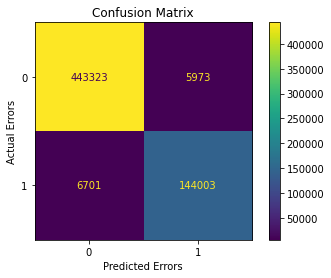

In [6]:
# Analysis
print("Total Rows:", len(pred_labels))
print("Actual Errors:", true_errors.sum())
print("Estimated Errors:", pred_errors.sum())
print("\nAccuracy:", round(accuracy_score(true_errors, pred_errors), 3))
print("Precision:", round(precision_score(true_errors, pred_errors), 3))
print("Recall:", round(recall_score(true_errors, pred_errors), 3))

# Confusion matrix
cm = confusion_matrix(true_errors, pred_errors)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Errors")
plt.ylabel("Actual Errors")
plt.show()

# 2. Testing Models with Noisy Data

In this section, we use a cleanlab function to make predictions on the partially mislabeled data using various scikit-learn compatibles models. We will do the following for each model:

1. Get a baseline by training the vanilla model on the ~1/4 mislabeled training data
2. Use `LearningWithNoisyLabels` to wrap the model and train on the same folds.

We check each of the following models:

* Logistic Regression
* Ridge Regression
* Linear Discriminant Analysis
* SGDClassifier
* XGBoost
* Multi-layer Perceptron Classifier

**Note (1):** The wrapper expects a scikit-learn compatible estimators with `.fit()`, `.predict()` and `.predict_proba()` methods. Not all of these estimators have `.predict_proba()` methods so we have to extend them by defining our own (using the decision function and softmax).

**Note (2):** The wrapper function attempts to fix the mislabeled data using cross-validation so instead of training one model per fold, we are actually training 5 models per fold. Hence, we should expect significantly longer training times.

## Scoring Functions

The following functions accept a scikit-learn compatible model or pipeline with fit, predict and predict_proba methods and return auc scores, out-of-fold predictions and test set predictions (averaged over each fold) for the vanilla models and the wrapped models, respectively.

In [7]:
# Scoring/Training Baseline Function
def train_model(sklearn_model):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['target'])):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx].to_numpy(), train['target'].iloc[train_idx].to_numpy()
        X_valid, y_valid = train[features].iloc[valid_idx].to_numpy(), train['target'].iloc[valid_idx].to_numpy()
        X_test = test[features]
        
        # Create model
        model = clone(sklearn_model)
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = model.predict_proba(X_valid)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / NUM_FOLDS
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_auc = roc_auc_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} (AUC): {round(fold_auc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_auc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    print("\nAverage AUC:", round(scores.mean(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return scores, test_preds, oof_preds

In [8]:
# Scoring/Training function for LearningWithNoisyLabels
def train_noisy_model(sklearn_model):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['target'])):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx].to_numpy(), train['target'].iloc[train_idx].to_numpy()
        X_valid, y_valid = train[features].iloc[valid_idx].to_numpy(), train['target'].iloc[valid_idx].to_numpy()
        X_test = test[features]
        
        # Create model
        model = LearningWithNoisyLabels(
            clf = clone(sklearn_model)
        )
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = model.predict_proba(X_valid)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / NUM_FOLDS
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_auc = roc_auc_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} (AUC): {round(fold_auc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_auc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    print("\nAverage AUC:", round(scores.mean(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return scores, test_preds, oof_preds

## 2.1 Logistic Regression

In [9]:
# Logistic Regression
logit_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver = 'saga',
        random_state = RANDOM_SEED,
        n_jobs = -1,
    ),
)

In [10]:
# Logistic Regression Baseline
logit_scores, logit_preds, logit_oof = train_model(logit_pipeline)

submission['target'] = logit_preds
submission.to_csv('logit_submission.csv', index=False)


Fold 0 (AUC): 0.75052 in 16.3s.
Fold 1 (AUC): 0.74699 in 16.21s.
Fold 2 (AUC): 0.75135 in 14.44s.
Fold 3 (AUC): 0.74784 in 14.83s.
Fold 4 (AUC): 0.74912 in 15.82s.
Fold 5 (AUC): 0.74953 in 16.71s.
Fold 6 (AUC): 0.75089 in 17.12s.
Fold 7 (AUC): 0.7461 in 15.79s.

Average AUC: 0.74904
Training Time: 127.21s


In [11]:
# Logistic Regression w/ Wrapper
noisy_logit_scores, noisy_logit_preds, noisy_logit_oof = train_noisy_model(logit_pipeline)

submission['target'] = noisy_logit_preds
submission.to_csv('noisy_logit_submission.csv', index=False)


Fold 0 (AUC): 0.75059 in 134.5s.
Fold 1 (AUC): 0.74718 in 139.96s.
Fold 2 (AUC): 0.75141 in 139.6s.
Fold 3 (AUC): 0.74795 in 136.98s.
Fold 4 (AUC): 0.74919 in 138.38s.
Fold 5 (AUC): 0.74964 in 137.78s.
Fold 6 (AUC): 0.75106 in 139.06s.
Fold 7 (AUC): 0.74626 in 138.98s.

Average AUC: 0.74916
Training Time: 1105.25s


## 2.2 Ridge Regression

The wrapper function expects an estimator with a `predict_proba` method, so we create an equivalent using softmax:

In [12]:
# Class extending Ridge Regression
class ExtendedRidgeClassifier(RidgeClassifier):
    def predict_proba(self, X):
        temp = self.decision_function(X)
        return softmax(np.c_[-temp, temp])
    
# Ridge Regression
ridge_pipeline = make_pipeline(
    StandardScaler(),
    ExtendedRidgeClassifier(random_state = RANDOM_SEED),
)

In [13]:
# Ridge Regression Baseline
ridge_scores, ridge_preds, ridge_oof = train_model(ridge_pipeline)

submission['target'] = ridge_preds
submission.to_csv('ridge_submission.csv', index=False)


Fold 0 (AUC): 0.75042 in 4.75s.
Fold 1 (AUC): 0.74693 in 4.04s.
Fold 2 (AUC): 0.75133 in 4.04s.
Fold 3 (AUC): 0.74771 in 4.03s.
Fold 4 (AUC): 0.74899 in 4.06s.
Fold 5 (AUC): 0.74949 in 4.35s.
Fold 6 (AUC): 0.7508 in 4.05s.
Fold 7 (AUC): 0.74599 in 4.0s.

Average AUC: 0.74896
Training Time: 33.32s


In [14]:
# Ridge Regression w/ Wrapper
noisy_ridge_scores, noisy_ridge_preds, noisy_ridge_oof = train_noisy_model(ridge_pipeline)

submission['target'] = noisy_ridge_preds
submission.to_csv('noisy_ridge_submission.csv', index=False)


Fold 0 (AUC): 0.75022 in 19.81s.
Fold 1 (AUC): 0.74686 in 19.61s.
Fold 2 (AUC): 0.75132 in 19.73s.
Fold 3 (AUC): 0.74751 in 19.52s.
Fold 4 (AUC): 0.74875 in 19.84s.
Fold 5 (AUC): 0.74943 in 19.89s.
Fold 6 (AUC): 0.75062 in 19.42s.
Fold 7 (AUC): 0.74589 in 19.6s.

Average AUC: 0.74883
Training Time: 157.42s


## 2.3 Linear Discriminant Analysis

In [15]:
# Linear Discriminant Analysis
lda_pipeline = make_pipeline(
    StandardScaler(),
    LinearDiscriminantAnalysis(),
)

In [16]:
lda_scores, lda_preds, lda_oof = train_model(lda_pipeline)

submission['target'] = lda_preds
submission.to_csv('lda_submission.csv', index=False)


Fold 0 (AUC): 0.75042 in 14.2s.
Fold 1 (AUC): 0.74693 in 14.3s.
Fold 2 (AUC): 0.75133 in 14.89s.
Fold 3 (AUC): 0.74771 in 13.9s.
Fold 4 (AUC): 0.74899 in 14.83s.
Fold 5 (AUC): 0.74949 in 14.76s.
Fold 6 (AUC): 0.7508 in 13.88s.
Fold 7 (AUC): 0.74599 in 13.08s.

Average AUC: 0.74896
Training Time: 113.85s


In [17]:
noisy_lda_scores, noisy_lda_preds, noisy_lda_oof = train_noisy_model(lda_pipeline)

submission['target'] = noisy_lda_preds
submission.to_csv('noisy_lda_submission.csv', index=False)


Fold 0 (AUC): 0.75022 in 60.23s.
Fold 1 (AUC): 0.74686 in 60.96s.
Fold 2 (AUC): 0.75132 in 61.04s.
Fold 3 (AUC): 0.7475 in 60.34s.
Fold 4 (AUC): 0.74875 in 61.05s.
Fold 5 (AUC): 0.74942 in 61.16s.
Fold 6 (AUC): 0.75062 in 60.47s.
Fold 7 (AUC): 0.74589 in 61.33s.

Average AUC: 0.74883
Training Time: 486.59s


## 2.4 SGDClassifier

We use the parameters borrowed from [this notebook](https://www.kaggle.com/kaaveland/tps-nov-2021-some-models-that-work-ok). Again, since the wrapper function expects an estimator with a `predict_proba` method, we create an equivalent using softmax:

In [18]:
# Extended SGDClassifier
class ExtendedSGDClassifier(SGDClassifier):
    def predict_proba(self, X):
        temp = self.decision_function(X)
        return softmax(np.c_[-temp, temp])

# SGDClassifier
sgd_pipeline = make_pipeline(
    RobustScaler(), 
    ExtendedSGDClassifier(
        loss='hinge', 
        learning_rate='adaptive', 
        penalty='l2', 
        alpha=1e-3, 
        eta0=0.025,
        random_state = RANDOM_SEED
    )
)

In [19]:
sgd_scores, sgd_preds, sgd_oof = train_model(sgd_pipeline)

submission['target'] = sgd_preds
submission.to_csv('sgd_submission.csv', index=False)


Fold 0 (AUC): 0.75056 in 21.04s.
Fold 1 (AUC): 0.74703 in 19.29s.
Fold 2 (AUC): 0.7514 in 19.14s.
Fold 3 (AUC): 0.74786 in 20.1s.
Fold 4 (AUC): 0.74914 in 22.19s.
Fold 5 (AUC): 0.7496 in 19.72s.
Fold 6 (AUC): 0.75097 in 20.0s.
Fold 7 (AUC): 0.74615 in 20.55s.

Average AUC: 0.74909
Training Time: 162.03s


In [20]:
noisy_sgd_scores, noisy_sgd_preds, noisy_sgd_oof = train_noisy_model(sgd_pipeline)

submission['target'] = noisy_sgd_preds
submission.to_csv('noisy_sgd_submission.csv', index=False)


Fold 0 (AUC): 0.75062 in 95.79s.
Fold 1 (AUC): 0.74721 in 100.82s.
Fold 2 (AUC): 0.75152 in 103.5s.
Fold 3 (AUC): 0.74797 in 96.53s.
Fold 4 (AUC): 0.7492 in 98.85s.
Fold 5 (AUC): 0.74962 in 98.77s.
Fold 6 (AUC): 0.75103 in 97.25s.
Fold 7 (AUC): 0.74629 in 95.59s.

Average AUC: 0.74918
Training Time: 787.1s


## 2.5 Naive Bayes Classifier

In [21]:
# Naive Bayes Classifier
nb_pipeline = make_pipeline(
    MinMaxScaler(),
    MultinomialNB(),
)

In [22]:
nb_scores, nb_preds, nb_oof = train_model(nb_pipeline)

submission['target'] = nb_preds
submission.to_csv('nb_submission.csv', index=False)


Fold 0 (AUC): 0.72573 in 1.67s.
Fold 1 (AUC): 0.72295 in 1.37s.
Fold 2 (AUC): 0.72971 in 1.39s.
Fold 3 (AUC): 0.72346 in 1.36s.
Fold 4 (AUC): 0.72432 in 1.36s.
Fold 5 (AUC): 0.72661 in 1.41s.
Fold 6 (AUC): 0.7264 in 1.37s.
Fold 7 (AUC): 0.72239 in 1.36s.

Average AUC: 0.7252
Training Time: 11.27s


In [23]:
noisy_nb_scores, noisy_nb_preds, noisy_nb_oof = train_noisy_model(nb_pipeline)

submission['target'] = noisy_nb_preds
submission.to_csv('noisy_nb_submission.csv', index=False)


Fold 0 (AUC): 0.7231 in 8.04s.
Fold 1 (AUC): 0.72032 in 7.91s.
Fold 2 (AUC): 0.72714 in 7.88s.
Fold 3 (AUC): 0.72086 in 7.86s.
Fold 4 (AUC): 0.72175 in 7.85s.
Fold 5 (AUC): 0.72389 in 7.85s.
Fold 6 (AUC): 0.72371 in 7.87s.
Fold 7 (AUC): 0.71999 in 7.95s.

Average AUC: 0.7226
Training Time: 63.22s


## 2.6 Multi-Layer Perceptron Classifier

In [24]:
# Multi-layer Perceptron Classifier
mlp_pipeline = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(128, 64),
        batch_size = 256, 
        early_stopping = True,
        validation_fraction = 0.2,
        n_iter_no_change = 5,
        random_state = RANDOM_SEED
    ),
)

In [25]:
mlp_scores, mlp_preds, mlp_oof = train_model(mlp_pipeline)

submission['target'] = mlp_preds
submission.to_csv('mlp_submission.csv', index=False)


Fold 0 (AUC): 0.75289 in 92.3s.
Fold 1 (AUC): 0.74966 in 79.72s.
Fold 2 (AUC): 0.75331 in 66.45s.
Fold 3 (AUC): 0.75164 in 84.99s.
Fold 4 (AUC): 0.7532 in 72.78s.
Fold 5 (AUC): 0.75316 in 86.14s.
Fold 6 (AUC): 0.7546 in 79.96s.
Fold 7 (AUC): 0.75026 in 72.81s.

Average AUC: 0.75234
Training Time: 635.16s


In [26]:
noisy_mlp_scores, noisy_mlp_preds, noisy_mlp_oof = train_noisy_model(mlp_pipeline)

submission['target'] = noisy_mlp_preds
submission.to_csv('noisy_mlp_submission.csv', index=False)


Fold 0 (AUC): 0.74979 in 405.98s.
Fold 1 (AUC): 0.74689 in 366.66s.
Fold 2 (AUC): 0.75084 in 384.15s.
Fold 3 (AUC): 0.7488 in 388.0s.
Fold 4 (AUC): 0.75032 in 407.19s.
Fold 5 (AUC): 0.74919 in 407.3s.
Fold 6 (AUC): 0.75024 in 404.54s.
Fold 7 (AUC): 0.74585 in 400.8s.

Average AUC: 0.74899
Training Time: 3164.61s


## 2.7 XGBoost with Linear Models

In [27]:
# XGBoost Classifier
xgb_pipeline = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        booster = 'gblinear',
        eval_metric = 'auc',
        random_state = RANDOM_SEED
    ),
)

In [28]:
xgb_scores, xgb_preds, xgb_oof = train_model(xgb_pipeline)

submission['target'] = xgb_preds
submission.to_csv('xgb_submission.csv', index=False)


Fold 0 (AUC): 0.75052 in 21.02s.
Fold 1 (AUC): 0.74699 in 20.38s.
Fold 2 (AUC): 0.75135 in 20.09s.
Fold 3 (AUC): 0.74784 in 19.92s.
Fold 4 (AUC): 0.74912 in 20.56s.
Fold 5 (AUC): 0.74953 in 19.93s.
Fold 6 (AUC): 0.75089 in 19.9s.
Fold 7 (AUC): 0.7461 in 20.34s.

Average AUC: 0.74904
Training Time: 162.14s


In [29]:
noisy_xgb_scores, noisy_xgb_preds, noisy_xgb_oof = train_noisy_model(xgb_pipeline)

submission['target'] = noisy_xgb_preds
submission.to_csv('noisy_xgb_submission.csv', index=False)


Fold 0 (AUC): 0.75049 in 96.02s.
Fold 1 (AUC): 0.74698 in 96.13s.
Fold 2 (AUC): 0.75136 in 95.56s.
Fold 3 (AUC): 0.74795 in 95.08s.
Fold 4 (AUC): 0.7491 in 98.16s.
Fold 5 (AUC): 0.74946 in 94.93s.
Fold 6 (AUC): 0.75109 in 95.03s.
Fold 7 (AUC): 0.74612 in 95.84s.

Average AUC: 0.74907
Training Time: 766.75s


We see that the `LearningWithNoisyLabels` wrapper doesn't necessarily lead to better model performance. It may be worth exploring further, especially with better parameter tuning since we mostly only used default settings. However the training slow down may not be worthwhile.